In [2]:
!pip install vaderSentiment
!pip install wordcloud
!pip install lightgbm
!pip install imblearn 

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import NearMiss


plt.rc('figure',figsize=(8,7.5))

np.random.seed(2021)

In [4]:
dataset = pd.read_csv(r"C:\Users\galencar\Downloads\archive (7)\articles_data.csv")
dataset.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


In [5]:
na = pd.DataFrame(data = [dataset.isna().sum().tolist(), ["{:.2f}".format(i)+'%'\
            for i in (dataset.isna().sum() / dataset.shape[0]*100).tolist()]],
            columns = dataset.columns, index = ['Contagem NA', 'Porcentagem NA']).T.\
            sort_values(by = 'Contagem NA', ascending = False)

na.style.background_gradient(cmap = 'summer', subset = ['Contagem NA'])

,Contagem NA,Porcentagem NA
content,1292,12.38%
author,1020,9.77%
url_to_image,656,6.29%
engagement_reaction_count,118,1.13%
engagement_comment_count,118,1.13%
engagement_share_count,118,1.13%
engagement_comment_plugin_count,118,1.13%
description,24,0.23%
title,2,0.02%
top_article,2,0.02%


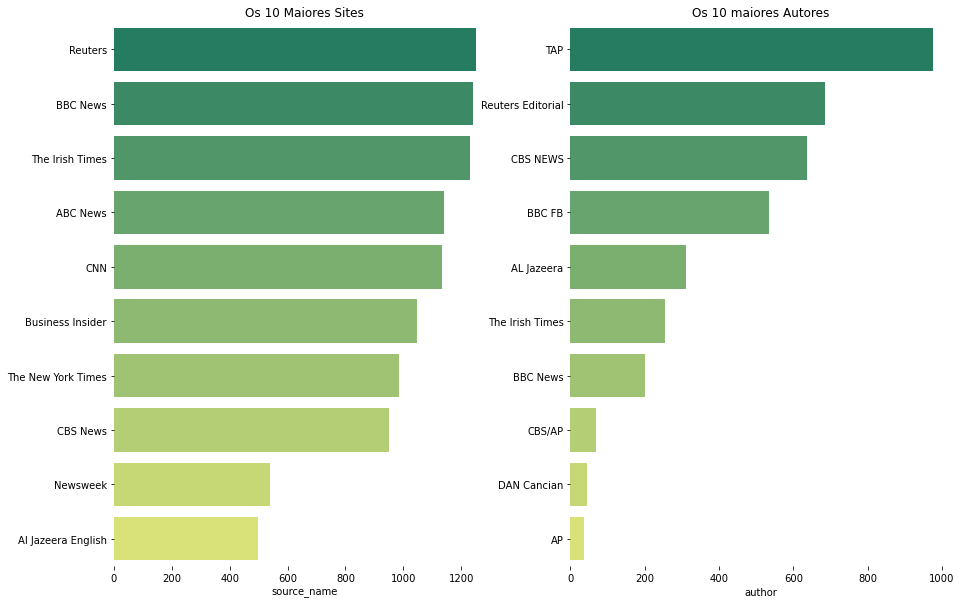

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
source_name = dataset["source_name"].dropna().value_counts()[:10]
author = dataset["author"].dropna().value_counts()[:10]

yticklabels = ['TAP',
               'Reuters Editorial',
               'CBS NEWS',
               'BBC FB',
               'AL Jazeera',
               'The Irish Times',
               'BBC News',
               'CBS/AP',
               'DAN Cancian', 
               'AP']
sns.barplot(x=source_name,y=source_name.index,palette='summer',ax=ax1)
sns.barplot(x=author,y=author.index,palette='summer',ax=ax2 )
sns.despine(bottom=True,left=True)
ax1.set(title='Os 10 Maiores Sites')
ax2.set(title='Os 10 maiores Autores')
ax2.set_yticklabels(yticklabels) ;

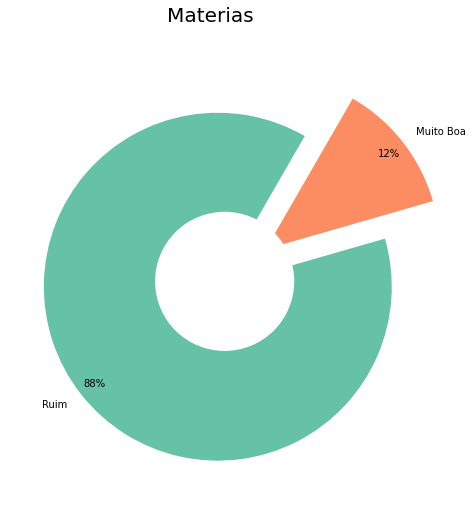

In [7]:
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Materias', size = 20, color = "black")
explode = ( 0.05, 0.3)
labels = ["Ruim","Muito Boa"]
sizes = dataset["top_article"].dropna().value_counts()
ax.pie(sizes, 
       explode=explode, 
       colors=sns.color_palette("Set2"),
       startangle=60,
       labels=labels,
       autopct='%1.0f%%',
       pctdistance=0.9)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

C:\Users\galencar\AppData\Local\Temp\ipykernel_2780\81042937.py:8: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax.set_yscale('Symlog')


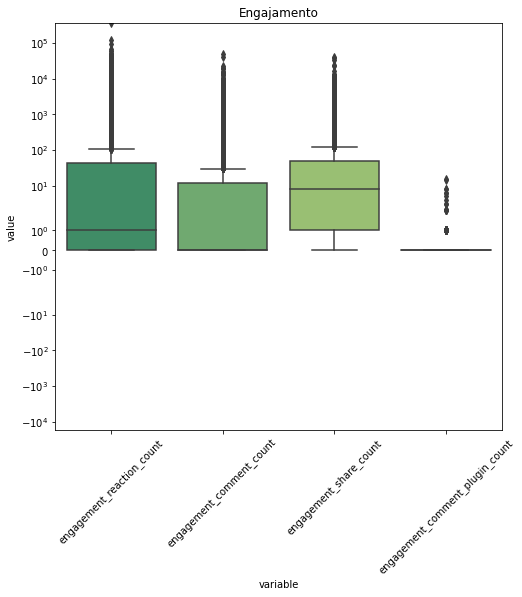

In [8]:
eng = ['engagement_reaction_count',
       'engagement_comment_count',
       'engagement_share_count',
       'engagement_comment_plugin_count'] 
ax = sns.boxplot(x="variable", y="value", data=pd.melt(dataset[eng]),palette='summer')
ax.set_title('Engajamento')
plt.xticks(rotation=45)
ax.set_yscale('Symlog')
plt.show()

In [9]:
pd.DataFrame(dataset["engagement_comment_plugin_count"].\
             value_counts().\
             reset_index().\
             rename(columns = {'index':'engagement_comment_plugin',
                               'engagement_comment_plugin_count':'Counts'})).\
            astype(int).\
            style.background_gradient(cmap="summer", subset=['Counts'])

,engagement_comment_plugin,Counts
0,0,10269
1,1,32
2,2,8
3,3,2
4,8,2
5,6,2
6,15,1
7,5,1
8,4,1
9,14,1


In [10]:
dataset['title'][0:5]

0    NTSB says Autopilot engaged in 2018 California...
1         Unemployment falls to post-crash low of 5.2%
2    Louise Kennedy AW2019: Long coats, sparkling t...
3    North Korean footballer Han joins Italian gian...
4    UK government lawyer says proroguing parliamen...
Name: title, dtype: object

In [11]:
def limpar_titulo(x:str):
       
    x=x.lower() 
    x = re.sub('\[.*?\]', '', x)
    x = re.sub('<.*?>+', '', x) 
    x = re.sub('https?://\S+|www\.\S+', '', x) 
    x = re.sub('[%s]' % re.escape(string.punctuation), '', x) 
    x = re.sub('\n', '', x) 
    x = re.sub('\w*\d\w*', '', x) 
    return x

In [12]:
dataset['clean_title'] = dataset['title'].astype(str).apply(limpar_titulo) 
dataset['clean_title'][0:5]

0    ntsb says autopilot engaged in  california tes...
1              unemployment falls to postcrash low of 
2    louise kennedy  long coats sparkling tweed dre...
3    north korean footballer han joins italian gian...
4    uk government lawyer says proroguing parliamen...
Name: clean_title, dtype: object

In [13]:
analyzer = SentimentIntensityAnalyzer()
def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

def sentiment(score):
    emotion = ""
    if score >= 0.5:
        emotion = "Positive"
    elif score <= -0.5:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

In [14]:
polarity_scores = dataset["clean_title"].astype("str").apply(compound_score)
dataset["Sentiment_Score"] = polarity_scores

In [15]:
dataset["Sentiment"] = dataset["Sentiment_Score"].apply(sentiment)

In [16]:
dataset.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count,clean_title,Sentiment_Score,Sentiment
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0,ntsb says autopilot engaged in california tes...,0.0000,Neutral
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0,unemployment falls to postcrash low of,-0.6124,Negative
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN,louise kennedy long coats sparkling tweed dre...,0.2960,Neutral
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0,north korean footballer han joins italian gian...,0.0000,Neutral
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0,uk government lawyer says proroguing parliamen...,-0.0951,Neutral


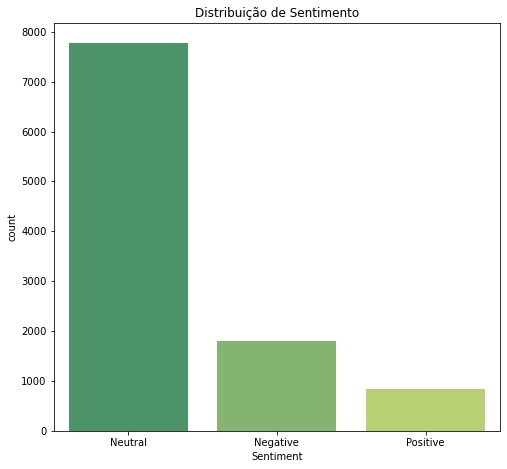

In [17]:
sns.countplot(data = dataset,x = "Sentiment",palette = "summer")
plt.title('Distribuição de Sentimento');

In [18]:
np.array(list(STOPWORDS))[0:5]

array(['i', "didn't", 'each', 'where', 'ever'], dtype='<U10')

In [19]:
dataset['published_at'] = pd.to_datetime(dataset['published_at'])

dataset['Day_Of_Week'] = dataset['published_at'].apply(lambda x: x.dayofweek)
dataset['Month'] = dataset['published_at'].apply(lambda x: x.month)
dataset['Year'] = dataset['published_at'].apply(lambda x: x.year)

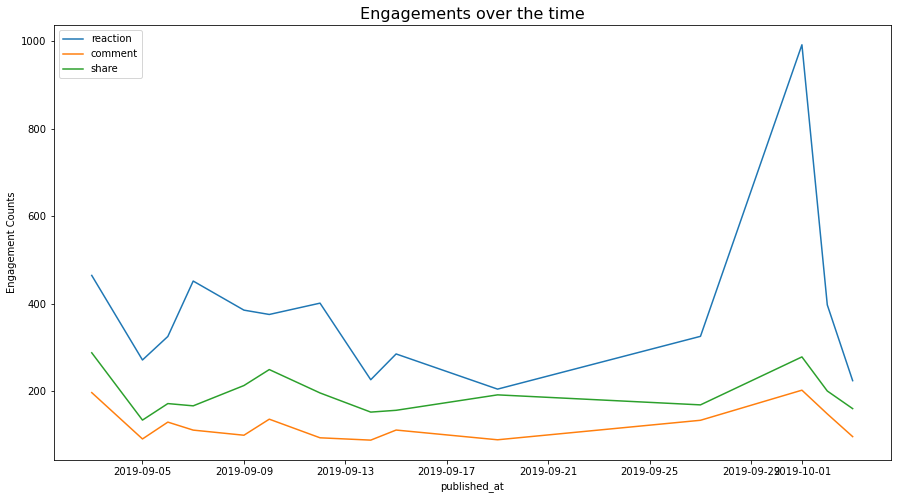

In [20]:
fig, ax1 = plt.subplots( figsize=[15, 8], facecolor = None)

date_mean = dataset.copy()
date_mean['published_at'] = pd.to_datetime(date_mean['published_at']).dt.normalize()
date_mean = date_mean.groupby(by='published_at').mean().reset_index()

ax1 = sns.lineplot(
    data=date_mean, x="published_at", y="engagement_reaction_count",label = 'reaction'
)

ax1 = sns.lineplot(
    data=date_mean, x="published_at", y="engagement_comment_count",label = 'comment'
)

ax1 = sns.lineplot(
    data=date_mean, x="published_at", y="engagement_share_count", label = 'share'
)
plt.ylabel('Engagement Counts')
plt.title('Engajamentos ao longo do tempo',fontsize=16);

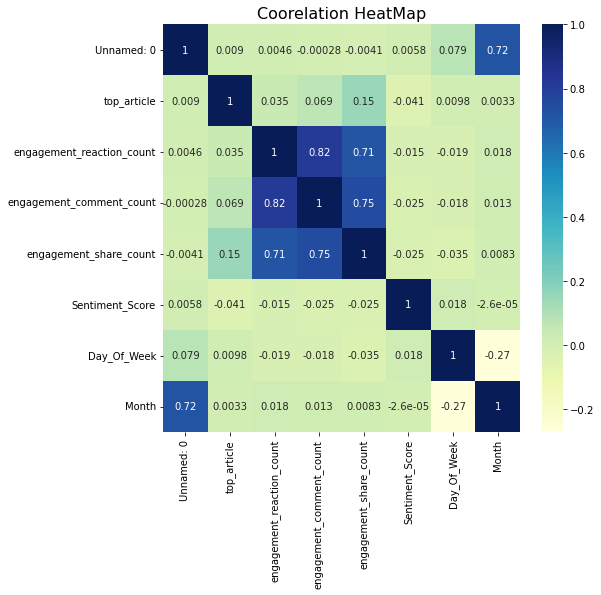

In [21]:
dataplot = sns.heatmap(dataset.drop(columns = ['Year','engagement_comment_plugin_count']).corr(),
                       cmap="YlGnBu", annot=True)
dataplot.set_title('Mapa de Calor de Coordenação',fontsize=16)  
plt.show()

In [22]:
dataset['clean_title'].fillna('Missing',inplace=True)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2),
                            dtype=np.float32, 
                            sublinear_tf=True, 
                            use_idf=True, 
                            smooth_idf=True)
train_tfidf = tfidf_vec.fit_transform(dataset['clean_title'])


In [23]:
list_labels = dataset["top_article"].fillna(0)

In [24]:
list_labels.value_counts()

0.0    9163
1.0    1274
Name: top_article, dtype: int64

In [25]:
OS = SMOTE()
X,Y = OS.fit_resample(train_tfidf,list_labels)

In [26]:
dataset['Popularity_Score'] = np.log1p((dataset['engagement_reaction_count'] + \
                         dataset['engagement_comment_count']+\
                         dataset['engagement_share_count']+\
                         dataset['engagement_comment_plugin_count']))

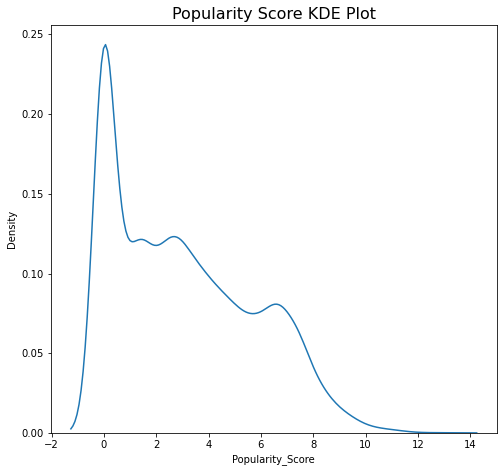

In [27]:
sns.kdeplot(dataset['Popularity_Score'])
plt.title('Gráfico de pontuação de popularidade do KDE Plot',fontsize=16);

In [28]:
dataset.groupby(by='source_name').\
    mean()['Popularity_Score'].\
    to_frame().\
    sort_values(by='Popularity_Score',
                ascending=False)

,Popularity_Score
source_name,
The New York Times,4.777518
CNN,4.418373
Business Insider,3.855361
Al Jazeera English,3.720652
The Wall Street Journal,3.499767
CBS News,3.163584
BBC News,2.929104
Newsweek,2.674136
Reuters,2.673019
